In [1]:
import os
import sys
import numpy as np
import os.path as pa
from astropy.table import Table
from scipy.interpolate import interp1d
from snlstm.SpecProc import HomogenizeSpec
from snlstm.PhaseEstimate import FitSingleSpecPhase, FitDoubleSpecPhase

import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import tensorflow
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)
from tensorflow.keras.models import load_model

#R_PATH = '/path/to/your/R-programming'
PATH_R = '/usr/bin/R'         # FIXME
assert pa.exists(PATH_R)

#SNDir = '/path/to/your/directory/of/sn2016coj'
SNDir = '/home/thomas/Lpackages/snlstm-extra/sn2016coj'
assert pa.exists(SNDir)

# NOTE: the default model file BiLSTM4ST.h5 can be found on Github
#MODEL_PATH = '/path/to/the/lstm/model'
MODEL_PATH = '/home/thomas/Lpackages/snlstm-extra/BiLSTM4ST.h5'
assert pa.exists(MODEL_PATH)


### Estimate Spectral Phases for the spectra of SN 2016coj (Assume the maximum time is unknown)
- SN 2016coj is a well-observed SN Ia in the latest BSNIP data release (Bibcode: 2020MNRAS.492.4325S).
- No spectroscopic data was included in our archival dataset, namely, it is a new SN for our predictive model.

- Example A: Only a single spectrum is observed at unknown phase.
    - We predict the spectral phase by feeding it into neural network with a hypothesized phase. 
    - The spectral phase is the estimated by maxmizing neural network predictive accuracy on this spectrum \
      (predictive MAPE error).
- Example B: Two phase-unknown spectra are oberved with certain delta-phase.
    - We predict their spectral phases by feeding the spectral pair into neural network \
      with a hypothesized phase of the first spectrum.
    - The spectral phase of the first spectrum (then also the second by adding delta-phase)is estimated \
      by maxmizing neural network predictive accuracy on the two spectra (average of two predictive MAPE errors).

In [2]:
# ** Basic information abour SN 2016coj
redshift = 0.0045     # redshift of SN 2016coj
MJD_Bmax = 57547.83   # MJD time of B maximum, estimated from phases given in the BSNIP paper

# ** Make a dictionary from phase to filepath for each raw spectrum of SN 2016coj
FilePath_dict = {-11.4: SNDir+'/sn2016coj-20160528.350-ui.csv',
                 -10.6: SNDir+'/sn2016coj-20160529.205-ui.csv',
                 -9.5: SNDir+'/sn2016coj-20160530.257-ui.csv',
                 -7.6: SNDir+'/sn2016coj-20160601.220-ui.csv',
                 -4.6: SNDir+'/sn2016coj-20160604.234-ui.csv',
                 -3.6: SNDir+'/sn2016coj-20160605.193-ui.csv',
                 -1.5: SNDir+'/sn2016coj-20160607.341-ui.csv',
                 -0.5: SNDir+'/sn2016coj-20160608.353-ui.csv',
                 +1.4: SNDir+'/sn2016coj-20160610.245-ui.csv',
                 +6.4: SNDir+'/sn2016coj-20160615.226-ui.csv',
                 +7.5: SNDir+'/sn2016coj-20160616.333-ui.csv',
                 +8.4: SNDir+'/sn2016coj-20160617.248-ui.csv',
                 +15.3: SNDir+'/sn2016coj-20160624.244-ui.csv',
                 +16.3: SNDir+'/sn2016coj-20160625.227-ui.csv',
                 +18.3: SNDir+'/sn2016coj-20160627.223-ui.csv',
                 +19.4: SNDir+'/sn2016coj-20160628.306-ui.csv'}

# ** Process the raw spectral data before feeding into neural network
#    Homogenize the spectrum, using the module snlstm.SpecProc.HomogenizeSpec

FeedSpecDICT = {}
for phase in FilePath_dict:
    AstSpec_Raw = Table.read(FilePath_dict[phase], format='ascii.csv')
    Wave_Raw, Flux_Raw = np.array(AstSpec_Raw['wavelength']), np.array(AstSpec_Raw['flux'])
    HomoSpec_dict = HomogenizeSpec.HS(Wave_Raw=Wave_Raw, Flux_Raw=Flux_Raw, deredshift=True, redshift=redshift)
    Wave_Homo, Flux_Homo = np.array(HomoSpec_dict['wavelength']), np.array(HomoSpec_dict['flux'])
    FeedSpecDICT[phase] = {'wavelength': Wave_Homo, 'flux': Flux_Homo}
    

In [3]:
# ** Example A: consider three cases with spectra at Pre-Max (-9.5d); Max (-0.5d); Post-Max (+8.4d), respectively.
#    Note: it might be a little bit time-consuming (a few mintues)

lstm_model = load_model(MODEL_PATH)
FITRES_DICTA = {}
for phase_real in [-9.5, -0.5, +6.4]:
    Wave_in = FeedSpecDICT[phase_real]['wavelength']
    Flux_in = FeedSpecDICT[phase_real]['flux']
    fitres = FitSingleSpecPhase.FSSP(Wave_in, Flux_in, lstm_model, PATH_R, \
        BadWaveMask_in=None, num_forward_pass=64, FAKE_MAPE_ERROR=0.2)
    FITRES_DICTA[phase_real] = fitres


In [42]:
# ** Example B: consider a case with two spectra at (-4.6d, -0.5d).
#    NOTE: delta-phase is determined by obstime and redshift even spectral phases are unknown. 
FITRES_DICTB = {}
phase_real_pair = (-4.6, -0.5)  # increasing order
Wave_in1 = FeedSpecDICT[phase_real_pair[0]]['wavelength']
Wave_in2 = FeedSpecDICT[phase_real_pair[1]]['wavelength']
Flux_in1 = FeedSpecDICT[phase_real_pair[0]]['flux']
Flux_in2 = FeedSpecDICT[phase_real_pair[1]]['flux']
delta_phase = phase_real_pair[1] - phase_real_pair[0]    
fitres = FitDoubleSpecPhase.FDSP(Wave_in1, Flux_in1, Wave_in2, Flux_in2, delta_phase, lstm_model, PATH_R, \
    BadWaveMask_in1=None, BadWaveMask_in2=None, num_forward_pass=64, FAKE_MAPE_ERROR=0.2)
FITRES_DICTB[phase_real_pair] = fitres


### Figure: Show the predictive accuacy

In [ ]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from astropy import visualization as vs
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rc('text', usetex=True)
%matplotlib nbagg


<IPython.core.display.Javascript object>


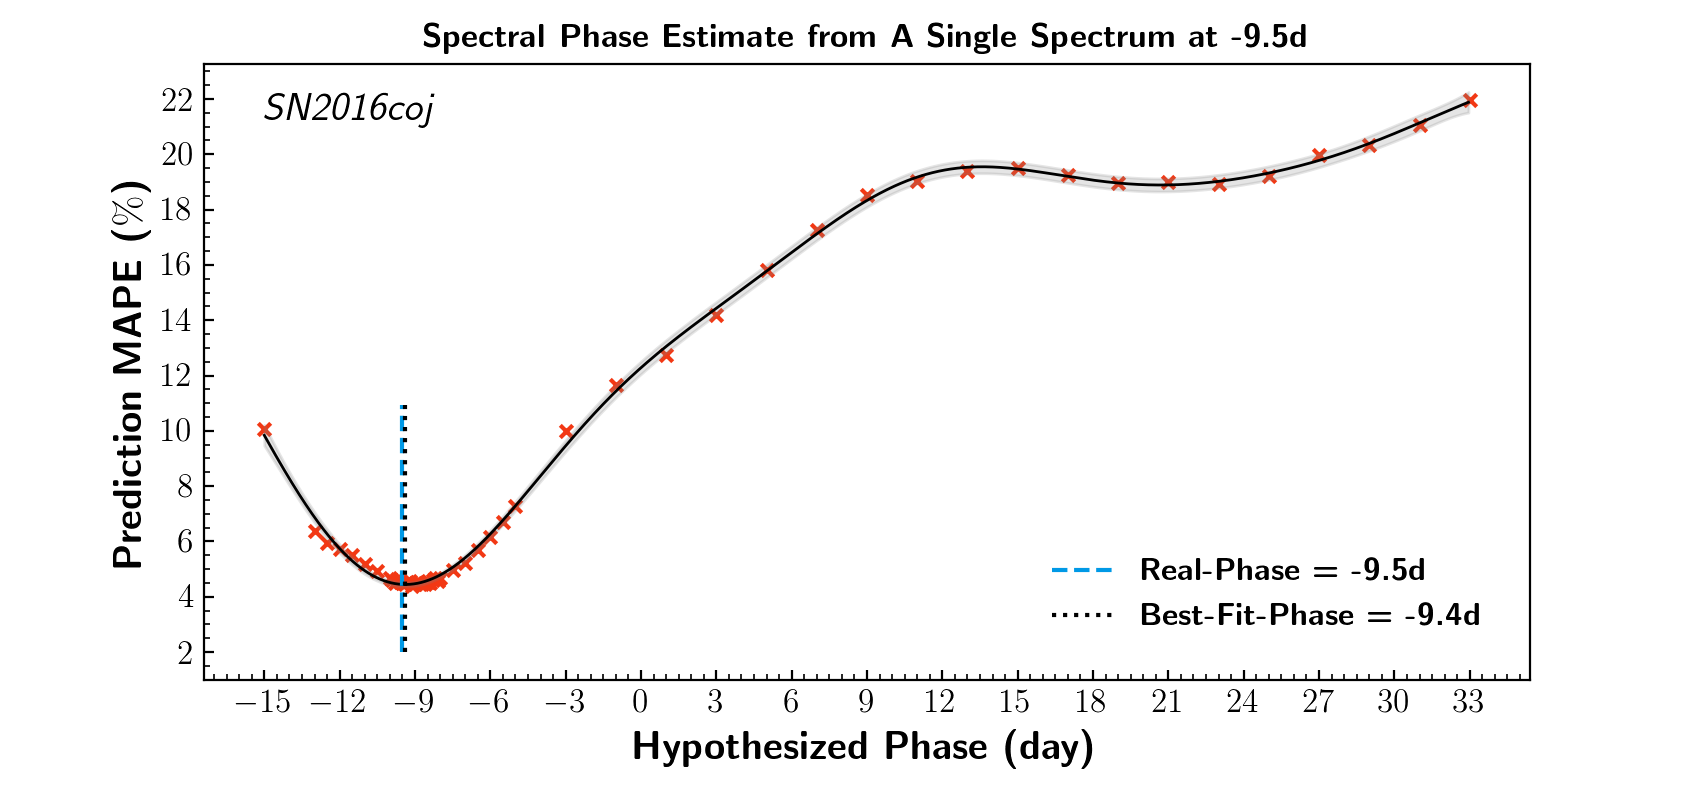

<IPython.core.display.Javascript object>


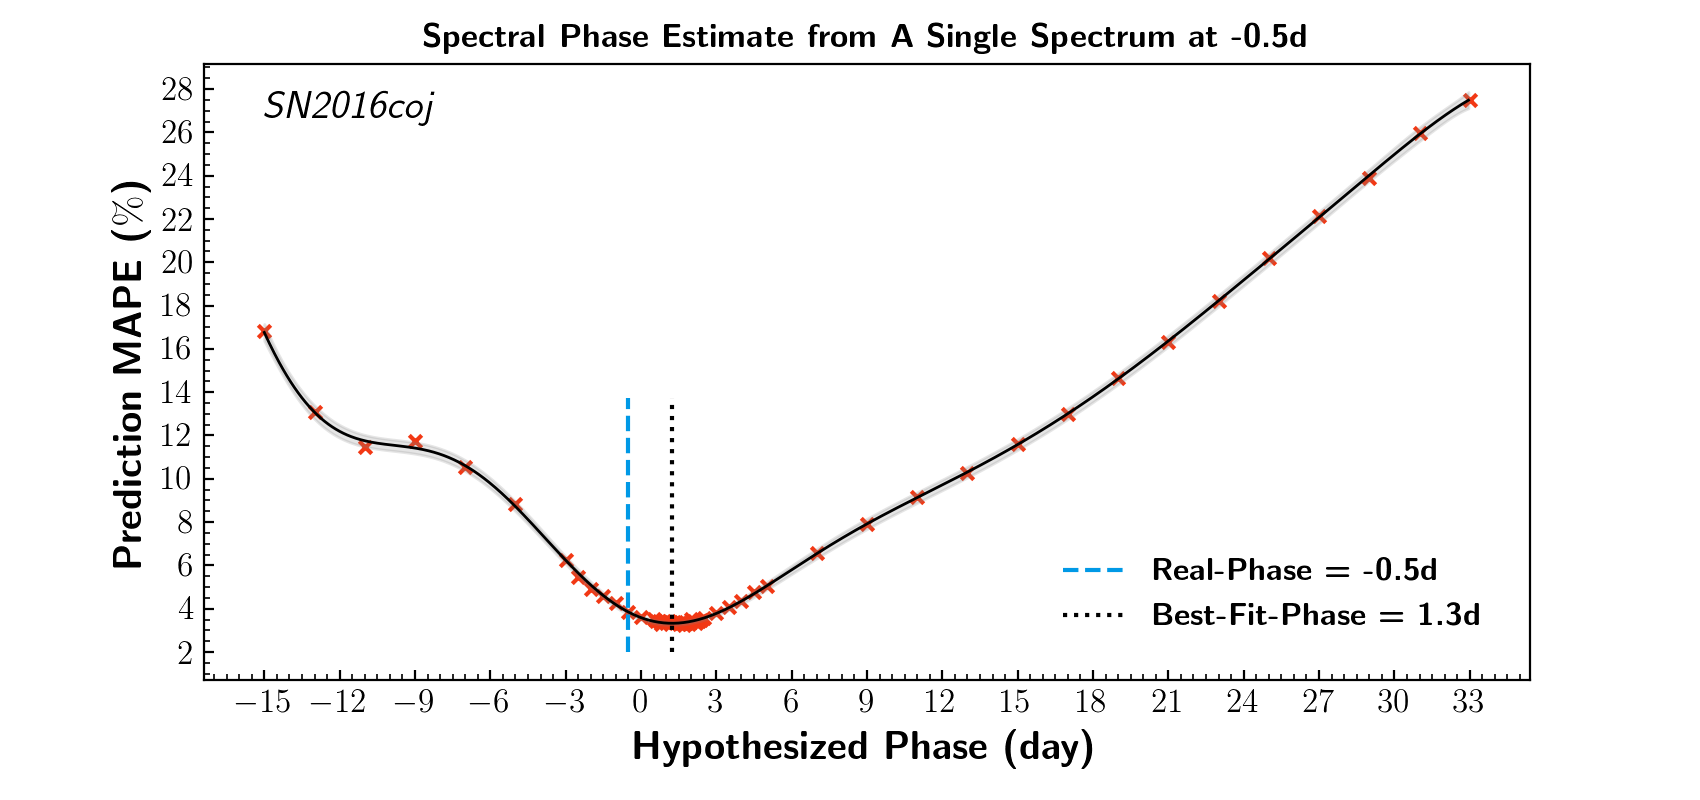

<IPython.core.display.Javascript object>


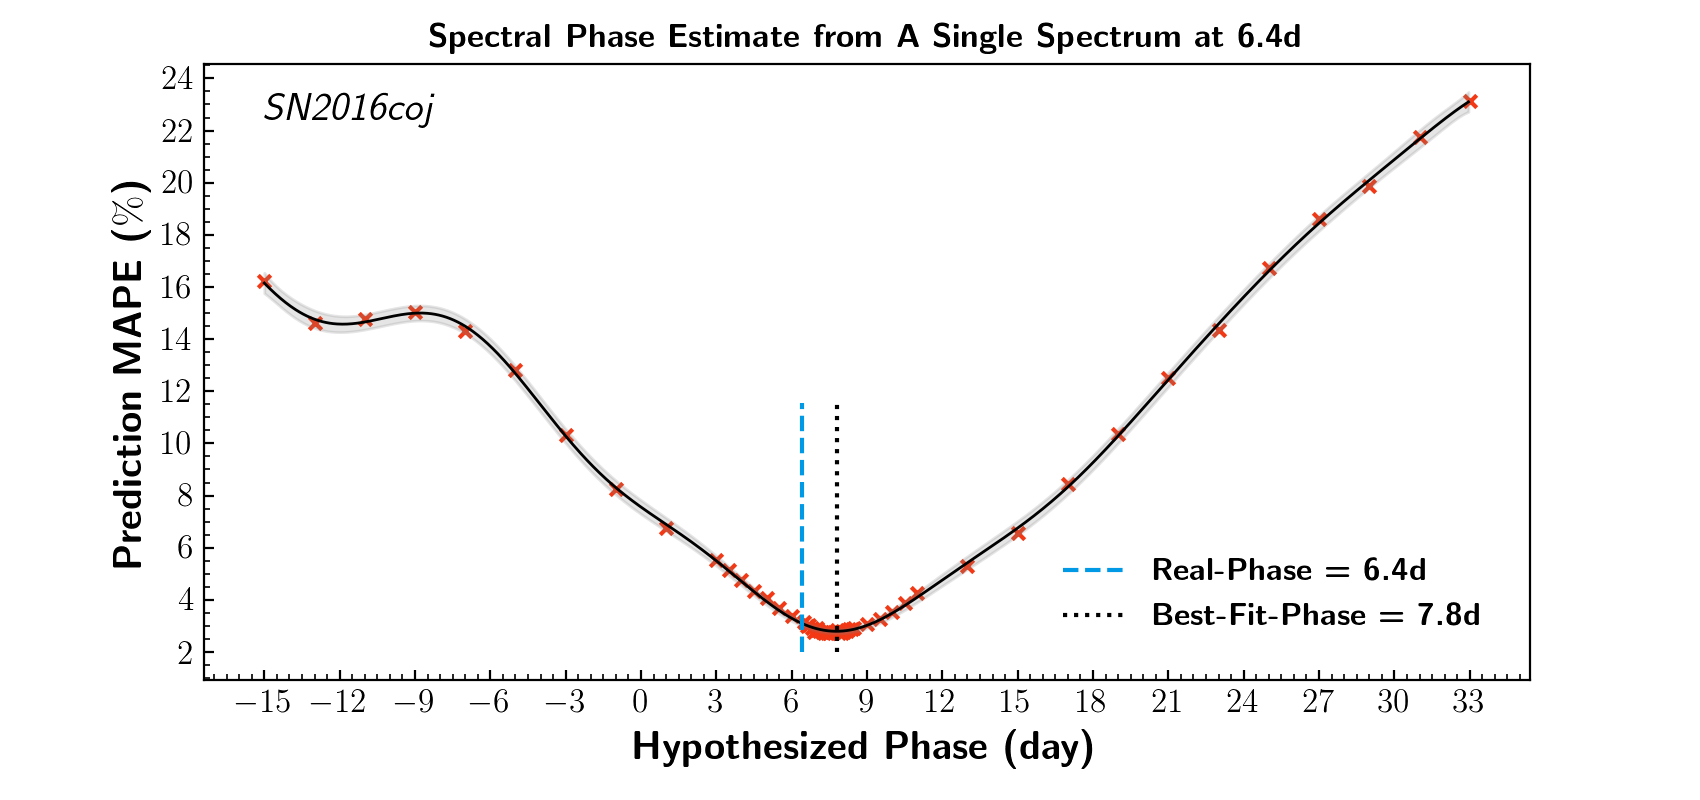

In [55]:
def plotA(phase_real, snlabel):
    
    PHA_HP, MAPE_HP, GPHA_HP, GMAPE_HP, eGMAPE_HP = FITRES_DICTA[phase_real] 
    phase_bestfit = GPHA_HP[np.argmin(GMAPE_HP)]
    
    fig = plt.figure(figsize=(8.5, 4))
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    fig.subplots_adjust(hspace=0.0, wspace=0.0, left=0.12, right=0.9, bottom=0.15, top=0.92)

    ax = plt.subplot(111)
    ax.scatter(PHA_HP, MAPE_HP, s=20.0, color='#F23814', marker='x')
    ax.plot(GPHA_HP, GMAPE_HP, color='black', linewidth=1.0)
    ax.fill_between(GPHA_HP, GMAPE_HP-2*eGMAPE_HP, GMAPE_HP+2*eGMAPE_HP, color='gray', alpha=0.2)
    
    TOP = np.max(GMAPE_HP)
    ax.vlines(x=[phase_real], ymin=2.0, ymax=0.5*TOP, color='#0099E6', linewidth=1.5, \
              linestyle='--', label=r'\textbf{Real-Phase = %.1fd}' %phase_real)
    ax.vlines(x=[phase_bestfit], ymin=2.0, ymax=0.5*TOP, color='black', linewidth=1.5, \
              linestyle='dotted', label=r'\textbf{Best-Fit-Phase = %.1fd}' %phase_bestfit)
    
    ax.annotate(r'\textit{%s}' %snlabel, xy=(-15.0, 0.97*TOP), fontsize=14.0, color='black')
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_major_locator(MultipleLocator(3.0))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(2.0))

    ax.set_xlabel(r'\textbf{Hypothesized Phase (day)}', fontsize=14)
    ax.set_ylabel(r'\textbf{Prediction MAPE ($\%$)}', fontsize=14)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)
    
    plt.title(r'\textbf{Spectral Phase Estimate from A Single Spectrum at %.1fd}' %phase_real)
    plt.legend(loc=4, borderpad=1.0, frameon=False, fontsize=11.5)
    plt.show()
    
    return None

# ** Example A: Pre-maximum; Maximum; Post-Maximum
plotA(-9.5, 'SN2016coj')
plotA(-0.5, 'SN2016coj')
plotA(+6.4, 'SN2016coj')


<IPython.core.display.Javascript object>


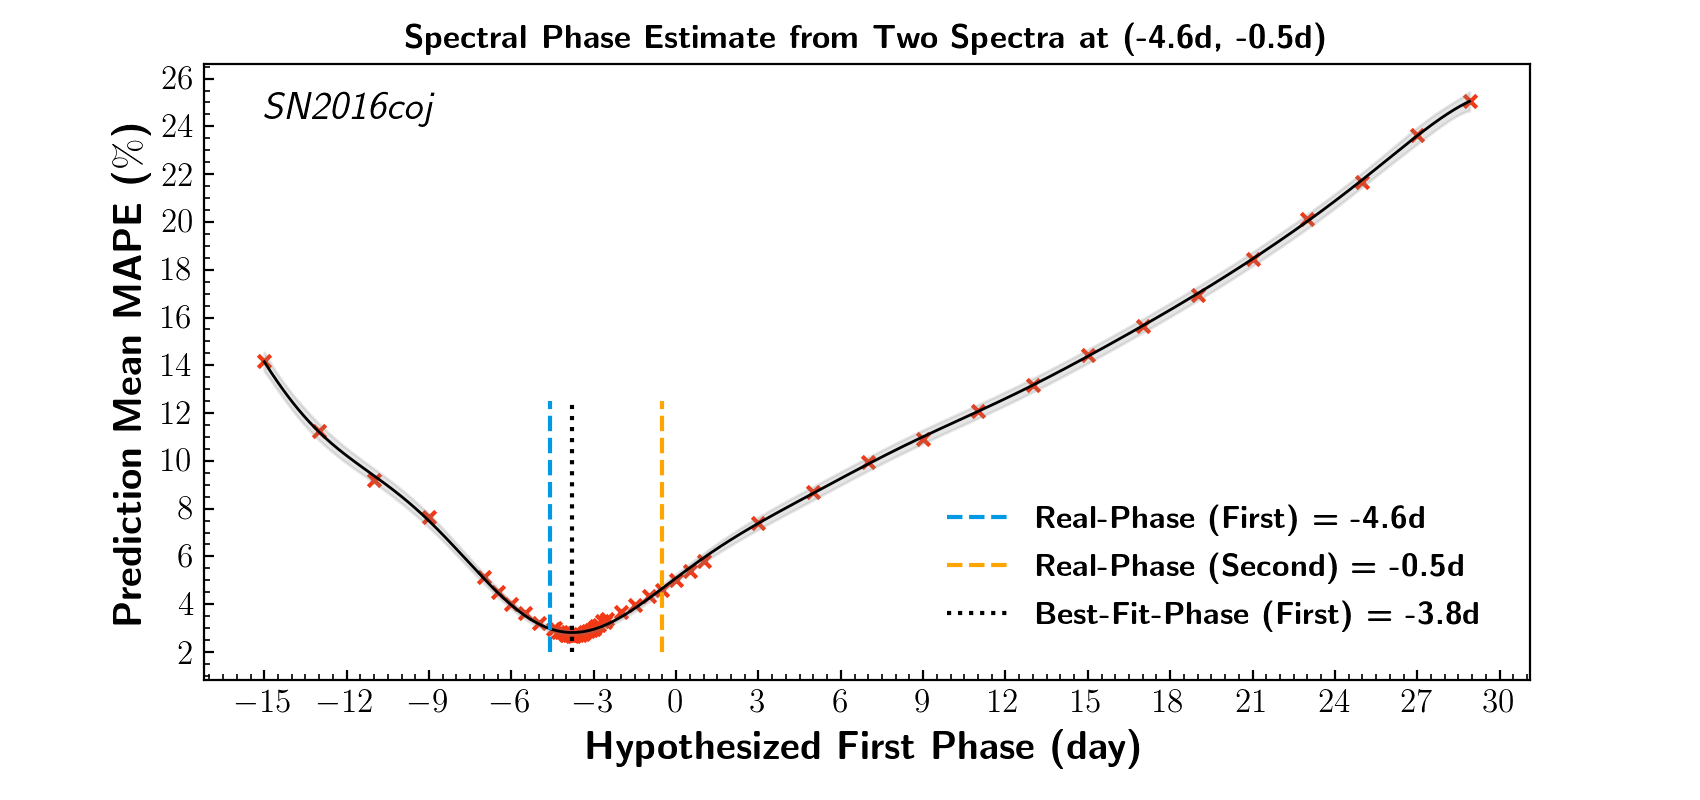

In [56]:
def plotB(phase_real_pair, snlabel):
    
    PHA_HP, MAPE_HP, GPHA_HP, GMAPE_HP, eGMAPE_HP = FITRES_DICTB[phase_real_pair]
    phase_bestfit = GPHA_HP[np.argmin(GMAPE_HP)]    # phase of the first spectrum
    
    fig = plt.figure(figsize=(8.5, 4))
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    fig.subplots_adjust(hspace=0.0, wspace=0.0, left=0.12, right=0.9, bottom=0.15, top=0.92)

    ax = plt.subplot(111)
    ax.scatter(PHA_HP, MAPE_HP, s=20.0, color='#F23814', marker='x')
    ax.plot(GPHA_HP, GMAPE_HP, color='black', linewidth=1.0)
    ax.fill_between(GPHA_HP, GMAPE_HP-2*eGMAPE_HP, GMAPE_HP+2*eGMAPE_HP, color='gray', alpha=0.2)
    
    TOP = np.max(GMAPE_HP)
    ax.vlines(x=[phase_real_pair[0]], ymin=2.0, ymax=0.5*TOP, color='#0099E6', linewidth=1.5, \
              linestyle='--', label=r'\textbf{Real-Phase (First) = %.1fd}' %phase_real_pair[0])
    ax.vlines(x=[phase_real_pair[1]], ymin=2.0, ymax=0.5*TOP, color='orange', linewidth=1.5, \
              linestyle='--', label=r'\textbf{Real-Phase (Second) = %.1fd}' %phase_real_pair[1])
    ax.vlines(x=[phase_bestfit], ymin=2.0, ymax=0.5*TOP, color='black', linewidth=1.5, \
              linestyle='dotted', label=r'\textbf{Best-Fit-Phase (First) = %.1fd}' %phase_bestfit)
    
    ax.annotate(r'\textit{%s}' %snlabel, xy=(-15.0, 0.97*TOP), fontsize=14.0, color='black')
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_major_locator(MultipleLocator(3.0))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(2.0))

    ax.set_xlabel(r'\textbf{Hypothesized First Phase (day)}', fontsize=14)
    ax.set_ylabel(r'\textbf{Prediction Mean MAPE ($\%$)}', fontsize=14)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)
    
    plt.title(r'\textbf{Spectral Phase Estimate from Two Spectra at (%.1fd, %.1fd)}' \
              %(phase_real_pair[0], phase_real_pair[1]))
    plt.legend(loc=4, borderpad=1.0, frameon=False, fontsize=11.5)
    plt.show()
    
    return None

# ** Example B
plotB((-4.6, -0.5), 'SN2016coj')